In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

california_housing_df = pd.read_csv('https://storage.googleapis.com/mledu-datasets/california_housing_train.csv',sep=',')
california_housing_df = california_housing_df.reindex(
    np.random.permutation(california_housing_df.index))
california_housing_df.head()

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12259,-121.48,38.56,46.0,1476.0,344.0,688.0,353.0,2.7316,134700.0
2972,-117.78,33.89,7.0,9729.0,1210.0,4160.0,1214.0,8.9088,415300.0
10139,-119.83,36.78,35.0,1789.0,357.0,933.0,357.0,2.5223,66200.0
650,-117.04,32.90,6.0,6525.0,826.0,3146.0,806.0,9.2858,436100.0
9887,-119.72,36.32,40.0,1185.0,221.0,676.0,256.0,2.2721,52600.0


In [2]:
def preprocess_features(california_housing_df):
    selected_features = california_housing_df[
        ['latitude',
         'longitude',
         'housing_median_age',
         'total_rooms',
         'total_bedrooms',
         'population',
         'households',
         'median_income']
    ]
    processed_features = selected_features.copy()
    
    #Create a synthetic feature
    processed_features['rooms_per_person'] = california_housing_df['total_rooms'] / california_housing_df['population']
    
    return processed_features

def preprocess_targets(california_housing_df):
    output_targets = pd.DataFrame()
    output_targets['median_house_value'] = california_housing_df['median_house_value'] / 1000.0
    return output_targets

In [3]:
#Split the dataset
training_examples = preprocess_features(california_housing_df.head(12000))
training_targets = preprocess_targets(california_housing_df.head(12000))

validation_examples = preprocess_features(california_housing_df.tail(5000))
validation_targets = preprocess_targets(california_housing_df.tail(5000))

display.display(training_examples.describe())
display.display(validation_examples.describe())
display.display(training_targets.describe())
display.display(validation_targets.describe())

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.00000,12000.000000,12000.000000,12000.000000
mean,35.605588,-119.544349,28.550083,2670.846500,544.728250,1439.12400,505.543750,3.893266,1.984940
std,2.132816,1.996938,12.637397,2255.912623,436.876796,1192.60622,398.543741,1.918676,1.117567
min,32.550000,-124.350000,1.000000,2.000000,1.000000,6.00000,1.000000,0.499900,0.018065
25%,33.930000,-121.742500,18.000000,1457.000000,295.000000,782.00000,280.000000,2.562500,1.528177
50%,34.240000,-118.480000,29.000000,2139.500000,435.000000,1171.00000,410.000000,3.553600,1.948302
75%,37.710000,-117.990000,37.000000,3166.250000,649.000000,1726.00000,605.000000,4.791100,2.303805
max,41.880000,-114.310000,52.000000,37937.000000,6445.000000,35682.00000,6082.000000,15.000100,55.222222


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,35.672352,-119.604730,28.683600,2578.427400,526.649000,1406.653800,490.849600,3.860327,1.971366
std,2.147639,2.024343,12.465752,1984.505245,381.816639,1032.314219,348.391056,1.882658,1.284682
min,32.540000,-124.300000,2.000000,11.000000,4.000000,3.000000,2.000000,0.499900,0.061605
25%,33.930000,-121.840000,18.000000,1469.750000,300.750000,801.000000,284.000000,2.581050,1.509479
50%,34.270000,-118.510000,29.000000,2108.000000,430.000000,1156.000000,406.000000,3.516100,1.926196
75%,37.722500,-118.010000,37.000000,3104.750000,648.000000,1710.000000,606.000000,4.725400,2.283534
max,41.950000,-114.560000,52.000000,23386.000000,4457.000000,12427.000000,4204.000000,15.000100,52.033333


,median_house_value
count,12000.000000
mean,207.854090
std,115.919248
min,14.999000
25%,120.000000
50%,180.950000
75%,266.000000
max,500.001000


,median_house_value
count,5000.000000
mean,205.973287
std,116.139309
min,14.999000
25%,118.275000
50%,178.800000
75%,262.100000
max,500.001000


In [4]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [8]:
def my_input_function(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    #Convert pandas data into a dict of np array
    features = {key:np.array(value) for key,value in dict(features).items()}
    #Construct dataset and configure batching repeating
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    #Shuffle the data if specified
    if shuffle:
        ds = ds.shuffle(10000)
    #Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [11]:
#Train model by using FTRL optimization algo
def train_model(learning_rate, steps, batch_size, feature_columns, training_examples, training_targets, validation_examples, validation_targets):
    
    periods = 10
    steps_per_period = steps/periods
    
    #Create a linear regressor object and optimizer
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    #Setup input functions
    training_input_function = lambda: my_input_function(training_examples, training_targets['median_house_value'], batch_size=batch_size)
    predict_training_input_function = lambda: my_input_function(training_examples, training_targets['median_house_value'], num_epochs=1, shuffle=False)
    predict_validation_input_function = lambda: my_input_function(validation_examples, validation_targets['median_house_value'], num_epochs=1, shuffle=False)
    
    #Train the model and calculate loss metrics
    print('Training model....')
    print('RMSE on training data: ')
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        #Train the model starting from prior state
        linear_regressor.train(input_fn=training_input_function, steps=steps_per_period)
        #Compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_function)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_function)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        #Calculate loss
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        #Print the cuurent loss
        print(' period %02d: %0.2f' % (period, training_root_mean_squared_error))
        
        #Add the loss metrics from this period to list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error) 
    print('Model training finished!!!')
    
    
    #Output the graph of loss metrics over periods
    plt.xlabel('Periods')
    plt.ylabel('RMSE')
    plt.title('Root Mean Squared Error vs Periods')
    plt.tight_layout()
    plt.plot(training_rmse, label='training')
    plt.plot(validation_rmse, label='validation')
    plt.legend()
    plt.show()
    
    return linear_regressor
    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_num_ps_replicas': 0, '_service': None, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FD9471CBA8>, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_session_config': None, '_master': '', '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_model_dir': 'C:\\Users\\STRIKE~1\\AppData\\Local\\Temp\\tmpkx6cowvw', '_task_type': 'worker', '_tf_random_seed': None, '_num_worker_replicas': 1}
Training model....
RMSE on training data: 
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\STRIKE~1\AppData\Local\Temp\tmpkx6cowvw\model.ckpt.
INFO:tensorflow:step = 1, loss = 5290774.0
INFO:tensorflow:Saving checkpoints for 50 into C:\Users\STRIKE~1\AppData\Local\Temp\tmpkx6cowvw\model.ckpt.
INFO:tensorflow:Loss for final ste

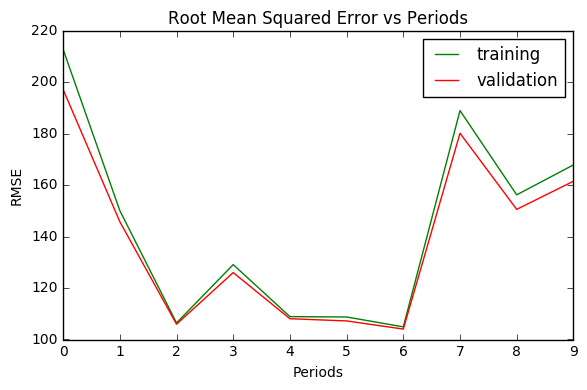

In [12]:
train_model(learning_rate=1.0,
           steps=500,
           batch_size=100,
           feature_columns=construct_feature_columns(training_examples),
           training_examples=training_examples,
           training_targets=training_targets,
           validation_examples=validation_examples,
           validation_targets=validation_targets)

In [20]:
#Bucketized Features (Binned Features)
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

households = tf.feature_column.numeric_column('households')
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(training_examples['households'], 7))

bucketized_households
boundaries=get_quantile_based_boundaries(training_examples['households'], 7)
boundaries

[219.0, 297.0, 371.0, 453.0, 567.0, 773.8571428571431]

In [21]:
def construct_feature_columns():
    households = tf.feature_column.numeric_column('households')
    longitue = tf.feature_column.numeric_column('longitude')
    latitude = tf.feature_column.numeric_column('latitude')
    housing_median_age = tf.feature_column.numeric_column('housing_median_age')
    median_income = tf.feature_column.numeric_column('median_income')
    rooms_per_person = tf.feature_column.numeric_column('rooms_per_person')
    
    #Divide households into 7 buckets
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(training_examples['households'], 7))
    
    #Divide longitude into 10 buckets
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitue, boundaries=get_quantile_based_boundaries(training_examples['longitude'], 10))
    
    #Divide latitude into 10 buckets
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(training_examples['latitude'], 10))
    
    #Divide housing_median_age into 7 buckets
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(training_examples['housing_median_age'], 7))
    
    #Divide median_income into 7 buckets
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(training_examples['median_income'], 7))
    
    #Divide rooms_per_person into 7 buckets
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(training_examples['rooms_per_person'], 7))
    
    feature_columns = set([
            bucketized_longitude,
            bucketized_latitude,
            bucketized_households,
            bucketized_housing_median_age,
            bucketized_median_income,
            bucketized_rooms_per_person
        ])
    return feature_columns

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_num_ps_replicas': 0, '_service': None, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FD9F6CC400>, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_session_config': None, '_master': '', '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_model_dir': 'C:\\Users\\STRIKE~1\\AppData\\Local\\Temp\\tmpa45tlu7b', '_task_type': 'worker', '_tf_random_seed': None, '_num_worker_replicas': 1}
Training model....
RMSE on training data: 
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\STRIKE~1\AppData\Local\Temp\tmpa45tlu7b\model.ckpt.
INFO:tensorflow:step = 1, loss = 5583621.0
INFO:tensorflow:Saving checkpoints for 50 into C:\Users\STRIKE~1\AppData\Local\Temp\tmpa45tlu7b\model.ckpt.
INFO:tensorflow:Loss for final ste

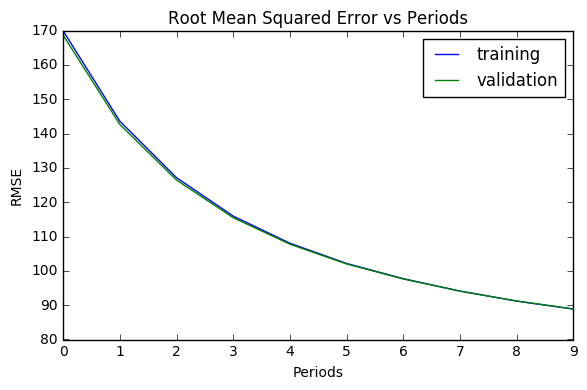

In [22]:
train_model(learning_rate=1.0,
           steps=500,
           batch_size=100,
           feature_columns=construct_feature_columns(),
           training_examples=training_examples,
           training_targets=training_targets,
           validation_examples=validation_examples,
           validation_targets=validation_targets)


In [25]:
#Feature-cross construct_feature_columns()
def construct_feature_columns():
    households = tf.feature_column.numeric_column('households')
    longitue = tf.feature_column.numeric_column('longitude')
    latitude = tf.feature_column.numeric_column('latitude')
    housing_median_age = tf.feature_column.numeric_column('housing_median_age')
    median_income = tf.feature_column.numeric_column('median_income')
    rooms_per_person = tf.feature_column.numeric_column('rooms_per_person')
    
    #Divide households into 7 buckets
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(training_examples['households'], 7))
    
    #Divide longitude into 10 buckets
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitue, boundaries=get_quantile_based_boundaries(training_examples['longitude'], 10))
    
    #Divide latitude into 10 buckets
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(training_examples['latitude'], 10))
    
    #Divide housing_median_age into 7 buckets
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(training_examples['housing_median_age'], 7))
    
    #Divide median_income into 7 buckets
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(training_examples['median_income'], 7))
    
    #Divide rooms_per_person into 7 buckets
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(training_examples['rooms_per_person'], 7))
    
    #Make a feature columns Long_x_lat with feature cross Long and Lat
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)
    
    feature_columns = set([
            bucketized_longitude,
            bucketized_latitude,
            bucketized_households,
            bucketized_housing_median_age,
            bucketized_median_income,
            bucketized_rooms_per_person,
            long_x_lat
        ])
    print(get_quantile_based_boundaries(training_examples['households'], 7))
    print(get_quantile_based_boundaries(training_examples['longitude'], 10))
    print(get_quantile_based_boundaries(training_examples['latitude'], 10))
    print(get_quantile_based_boundaries(training_examples['housing_median_age'], 7))
    print(get_quantile_based_boundaries(training_examples['median_income'], 7))
    print(get_quantile_based_boundaries(training_examples['rooms_per_person'], 7))
    print(long_x_lat)
    return feature_columns

[219.0, 297.0, 371.0, 453.0, 567.0, 773.8571428571431]
[-122.28, -121.96, -121.33, -119.82, -118.48, -118.3, -118.12, -117.88, -117.24]
[33.61, 33.86, 34.0, 34.09, 34.24, 36.59, 37.46, 37.8, 38.46]
[15.0, 19.0, 26.0, 32.0, 36.0, 43.0]
[2.1179285714285716, 2.6940285714285714, 3.2440857142857147, 3.848057142857143, 4.5625, 5.6390714285714285]
[1.2471236769921583, 1.6027412422458862, 1.8485414310624164, 2.045060301854928, 2.24357426972626, 2.526887851931816]
_CrossedColumn(keys=(_BucketizedColumn(source_column=_NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(33.61, 33.86, 34.0, 34.09, 34.24, 36.59, 37.46, 37.8, 38.46)), _BucketizedColumn(source_column=_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-122.28, -121.96, -121.33, -119.82, -118.48, -118.3, -118.12, -117.88, -117.24))), hash_bucket_size=1000, hash_key=None)
INFO:tensorflow:Using default config.
INFO

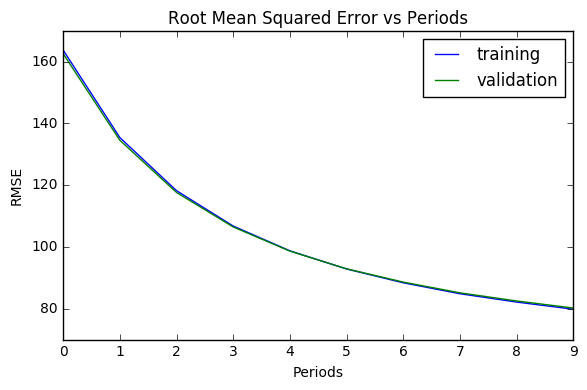

In [26]:
train_model(learning_rate=1.0,
           steps=500,
           batch_size=100,
           feature_columns=construct_feature_columns(),
           training_examples=training_examples,
           training_targets=training_targets,
           validation_examples=validation_examples,
           validation_targets=validation_targets)